In [1]:
import uproot
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector

ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict
from copy import copy

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from tqdm import tqdm

from pathlib import Path
import os

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = Path("src/HH4b/combine/binder/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

In [4]:
import glob

samples = {
    "VBF_HHto4B_CV_1_C2V_1_C3_1": "src/HH4b/combine/binder/vbf/all.root",
    "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00": "src/HH4b/combine/binder/ggf/all.root",
}

In [5]:
xsecs = {
    "VBF_HHto4B_CV_1_C2V_1_C3_1": 1.874,
    "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00": 34.43,
}

for key in xsecs:
    xsecs[key] = xsecs[key]

In [6]:
xsecs

{'VBF_HHto4B_CV_1_C2V_1_C3_1': 1.874,
 'GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00': 34.43}

In [7]:
events_dict = {}


for sample, file in samples.items():
    events_dict[sample] = nanoevents.NanoEventsFactory.from_root(
        file,
        schemaclass=nanoevents.NanoAODSchema,
    ).events()

In [8]:
d_PDGID = 1
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

In [9]:
def get_hists(mhh, weights):
    return np.histogram(mhh, np.logspace(np.log10(260), np.log10(1200), 30), weights=weights)


def get_hists_pt(pt, weights):
    return np.histogram(pt, np.logspace(np.log10(30), np.log10(1200), 30), weights=weights)

In [33]:
hists = []
hists_pt = []
integrals = []
integrals_pt = []

for sample in samples:
    events = events_dict[sample]
    subleading_250 = ak.count(events.FatJet.pt > 250, axis=1) >= 2
    leading_300 = ak.count(events.FatJet.pt > 300, axis=1) >= 1
    subleading_400 = ak.count(events.FatJet.pt > 400, axis=1) >= 2
    leading_500 = ak.count(events.FatJet.pt > 500, axis=1) >= 1
    print("all events", len(events))
    print(np.sum(leading_300))
    print(np.sum(subleading_250))
    print(np.sum(leading_300 & subleading_250))
    print("pt > 300, 250", np.sum(leading_300 * subleading_250))
    print("pt > 500, 400", np.sum(leading_500 * subleading_400))

    higgs = events.GenPart[
        (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
    ]
    mhh = (higgs[:, 0] + higgs[:, 1]).mass
    pth1 = np.maximum(higgs[:, 0].pt, higgs[:, 1].pt)
    pth2 = np.minimum(higgs[:, 0].pt, higgs[:, 1].pt)
    w = events.genWeight
    w = w * xsecs[sample] / np.sum(w)
    counts, bins = get_hists(mhh, w)
    integral = np.sum(w[mhh > 600])
    integral_pt = np.sum(w[pth1 > 300])
    counts_pt, bins_pt = get_hists_pt(pth1, w)
    print(sample, "total", np.sum(w))
    print(sample, "pt>300", np.sum(w[(pth1 > 300)]))
    print(sample, "mhh>600", np.sum(w[(mhh > 600)]))
    hists.append(counts)
    hists_pt.append(counts_pt)
    integrals.append(integral)
    integrals_pt.append(integral_pt)

all events 1526135
323165
136013
136013


ValueError: operands could not be broadcast together with shapes (1,1526135) (1,134550) 

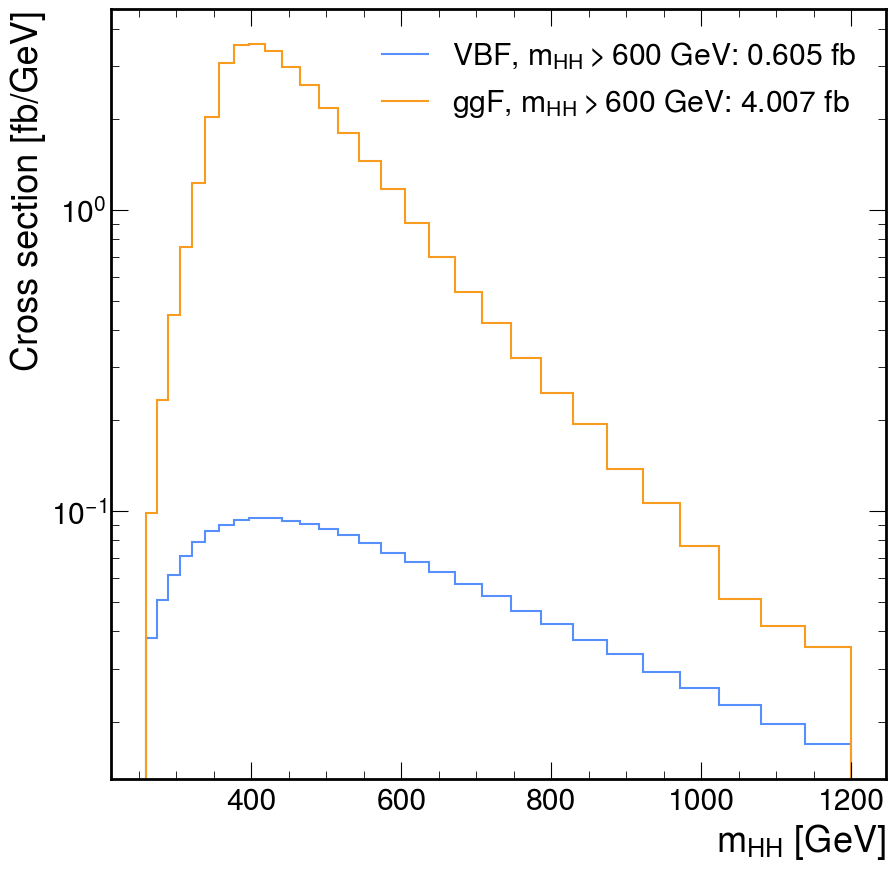

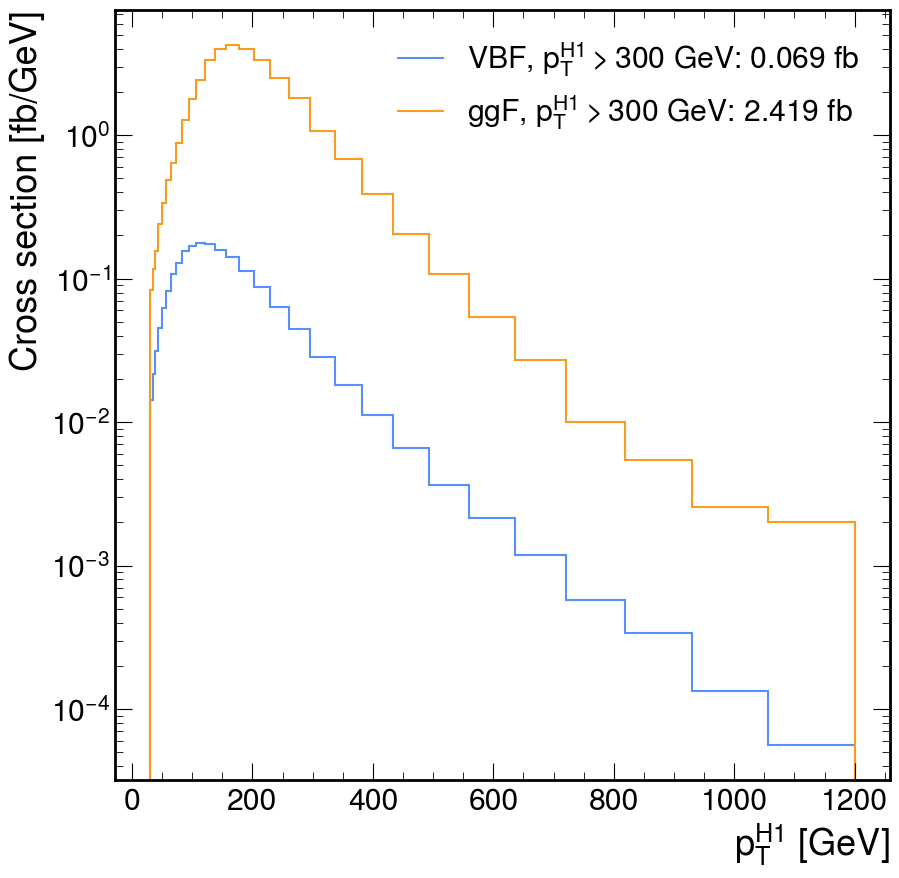

19.299866
18.516758


In [11]:
plt.figure()
hep.histplot(
    hists,
    bins,
    label=[
        f"VBF, $m_{{HH}} > 600$ GeV: {integrals[0]:.3f} fb",
        f"ggF, $m_{{HH}} > 600$ GeV: {integrals[1]:.3f} fb",
    ],
)
plt.yscale("log")
plt.xlabel(r"$m_{HH}$ [GeV]")
plt.ylabel("Cross section [fb/GeV]")
plt.legend()
plt.show()

plt.figure()
hep.histplot(
    hists_pt,
    bins_pt,
    label=[
        f"VBF, $p_{{T}}^{{H1}} > 300$ GeV: {integrals_pt[0]:.3f} fb",
        f"ggF, $p_{{T}}^{{H1}} > 300$ GeV: {integrals_pt[1]:.3f} fb",
    ],
)
plt.yscale("log")
plt.xlabel(r"$p_{T}^{H1}$ [GeV]")
plt.ylabel("Cross section [fb/GeV]")
plt.legend()
plt.show()

print(np.sum(hists[1]) / np.sum(hists[0]))
print(np.sum(hists_pt[1]) / np.sum(hists_pt[0]))